# Heart disease prediction

Import relevant libraries:

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np

Load data and print a preview of 5 first rows:

In [2]:
heart_disease = pd.read_csv("heart.csv")
columns = heart_disease.columns
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Exploratory data analysis (EDA):

In [3]:
shape = heart_disease.shape
print(f"The shape of the data is: {shape}")
print(f"Number of samples: {shape[0]}")
print(f"Number of features: {shape[1]}")

The shape of the data is: (918, 12)
Number of samples: 918
Number of features: 12


In [4]:
print(f"Number of duplicated samples is: {heart_disease.duplicated().sum()}")

Number of duplicated samples is: 0


In [5]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Min value of 'Cholesterol' and 'RestingBP' is 0 which is not valid for these features.
We'll take of it in the preprocess step:

## Data preprocess:
### Missing values:

At first look it seems like we don't have missing value at all:

In [6]:
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

But as we saw previously, the minimal value of 'Cholesterol' and 'RestingBP' is 0 which is not valid, thus we'll consider it as a missing value. for that purpose we'll replace all zero values in 'Cholesterol' and 'RestingBP' to NaN:

In [7]:
cols = ["RestingBP","Cholesterol"]
heart_disease[cols] = heart_disease[cols].replace({0:np.nan})
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,917.000000,746.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.540894,244.635389,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.999749,59.153524,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,207.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,275.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Now we are able to see that the values for 'Cholesterol' and 'RestingBP' are at normal range.
In addition we can see that we now have missing values in our data set:

In [8]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

To treat the missing value of 'RestingBP', we are going to remove the relevant sample:

In [9]:
heart_disease = heart_disease.dropna(subset=['RestingBP'])

We can see that the sample removal reduced the number of missing values (also in 'Cholesterol' column).

In [10]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

We are now going to treat the missing values in 'Cholesterol' column. Before we do that, we'll first examine the feature's distribution:

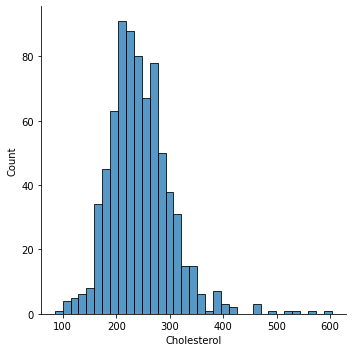

In [11]:
sns.displot(heart_disease.Cholesterol)

We can see that the data is skewed and may contain outliers. Outliers data points will have a significant impact on the mean and hence, in such cases, it is not recommended to use the mean for replacing the missing values.When the data is skewed, it is good to consider using the median value for replacing the missing values.

In [12]:
heart_disease['Cholesterol'] = heart_disease['Cholesterol'].fillna(heart_disease['Cholesterol'].median())

In [13]:
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [14]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,243.211559,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.430044,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Outliers:

In [15]:
#sns.boxplot(data=heart_disease, x='RestingBP')

In [16]:
#from scipy import stats
#heart_disease[int_columns][(np.abs(stats.zscore(heart_disease[int_columns])) < 4)]

In [17]:
#heart_disease[heart_disease.between(heart_disease.quantile(.25), heart_disease.quantile(.75))]

### Encoding Categorical Values:

In [18]:
heart_disease.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP         float64
Cholesterol       float64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [19]:
int_columns = heart_disease.select_dtypes("int64").columns.to_list()
object_columns = heart_disease.select_dtypes("object").columns.to_list()
print(f"The following features are numeric: {int_columns}")
print(f"The following features are non numeric: {object_columns}")

The following features are numeric: ['Age', 'FastingBS', 'MaxHR', 'HeartDisease']
The following features are non numeric: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


Check if all categorical features are assignd with values that they supposed to get.

In [20]:
for col in object_columns:
    print(f"\nThe distribution of categorical valeus in '{col}' feature is:")
    print(heart_disease[col].value_counts())


The distribution of categorical valeus in 'Sex' feature is:
M    724
F    193
Name: Sex, dtype: int64

The distribution of categorical valeus in 'ChestPainType' feature is:
ASY    496
NAP    202
ATA    173
TA      46
Name: ChestPainType, dtype: int64

The distribution of categorical valeus in 'RestingECG' feature is:
Normal    551
LVH       188
ST        178
Name: RestingECG, dtype: int64

The distribution of categorical valeus in 'ExerciseAngina' feature is:
N    546
Y    371
Name: ExerciseAngina, dtype: int64

The distribution of categorical valeus in 'ST_Slope' feature is:
Flat    459
Up      395
Down     63
Name: ST_Slope, dtype: int64


In [21]:
# heart_disease["ST_Up_slope"] = np.where(obj_df["ST_Slope"].str.contains("Up"), 1, 0)
# for later if I want to change features semantic.

Use label encoding on 'Sex', 'ExerciseAngina' and 'ST_Slope':

In [22]:
cat_to_num = {
            "Sex": {"M": 0, "F": 1},
            "ExerciseAngina": {"N": 0, "Y": 1},
            "ST_Slope": {"Down": 0, "Flat": 1, "Up": 2}
            }

In [23]:
heart_disease = heart_disease.replace(cat_to_num)
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,ATA,140.0,289.0,0,Normal,172,0,0.0,2,0
1,49,1,NAP,160.0,180.0,0,Normal,156,0,1.0,1,1
2,37,0,ATA,130.0,283.0,0,ST,98,0,0.0,2,0
3,48,1,ASY,138.0,214.0,0,Normal,108,1,1.5,1,1
4,54,0,NAP,150.0,195.0,0,Normal,122,0,0.0,2,0


Perform one hot encoding to 'ChestPainType' and 'RestingECG':

In [24]:
heart_disease = pd.get_dummies(heart_disease, columns=["ChestPainType", "RestingECG"], prefix=["CPT", "R_ECG"])
heart_disease.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,CPT_ASY,CPT_ATA,CPT_NAP,CPT_TA,R_ECG_LVH,R_ECG_Normal,R_ECG_ST
0,40,0,140.0,289.0,0,172,0,0.0,2,0,0,1,0,0,0,1,0
1,49,1,160.0,180.0,0,156,0,1.0,1,1,0,0,1,0,0,1,0
2,37,0,130.0,283.0,0,98,0,0.0,2,0,0,1,0,0,0,0,1
3,48,1,138.0,214.0,0,108,1,1.5,1,1,1,0,0,0,0,1,0
4,54,0,150.0,195.0,0,122,0,0.0,2,0,0,0,1,0,0,1,0


We can see now that we no longer have non-numeric data types in our data set:

In [25]:
heart_disease.dtypes

Age                 int64
Sex                 int64
RestingBP         float64
Cholesterol       float64
FastingBS           int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
CPT_ASY             uint8
CPT_ATA             uint8
CPT_NAP             uint8
CPT_TA              uint8
R_ECG_LVH           uint8
R_ECG_Normal        uint8
R_ECG_ST            uint8
dtype: object

### Feature Scaling:

In [26]:
# print("Features correlation plot:")
# sns.heatmap(heart_disease.corr())

In [27]:
# fig = px.histogram(heart_disease, 
#                  x="HeartDisease",
#                  color="Sex",
#                  hover_data=columns,
#                  title="Distribution of Heart Diseases",
#                  barmode="group")
# fig.show()

In [28]:
# fig=px.histogram(heart_disease,
#                  x="Sex",
#                  hover_data=heart_disease.columns,
#                  title="Sex Ratio in the Data")
# fig.show()

In [29]:
# fig=px.histogram(heart_disease,
#                  x="Age",
#                  color="Sex",
#                  hover_data=columns,
#                  title="Sex ratio with regard to age"
#                 )
# fig.show()

In [30]:
# fig=px.histogram(heart_disease,
#                  x="Age",
#                  color="HeartDisease",
#                  hover_data=columns,
#                  title="Sex ratio with respect to age"
#                 )
# fig.show()

In [31]:
# fig = px.box(heart_disease,y="Age",x="HeartDisease",title="Distrubution of Age")
# fig.show()

In [32]:
# fig = px.box(heart_disease,y="Age",x="HeartDisease", color="Sex", title="Distrubution of Age with respect to gender")
# fig.show()

In [33]:
# fig = px.box(heart_disease,y="RestingBP",x="HeartDisease",color="Sex",title="Distrubution of RestingBP with respect to gender")
# fig.show()

In [34]:
# fig = px.box(heart_disease,y="Cholesterol",x="HeartDisease",title="Distrubution of Cholesterol")
# fig.show()

# TODO:  Cholesterol data may contain anomalies - check that

In [35]:
# sns.boxplot(data=heart_disease, y='Cholesterol', x="HeartDisease")

In [36]:
#sns.displot(heart_disease.RestingBP)